# 📊 Projet Business Intelligence : Analyse Northwind Data Warehouse

Ce Notebook Jupyter utilise les données chargées dans le Data Warehouse `NorthwindDW` (via le script `etl.py`) pour générer les analyses clés.

**Outils utilisés :**
* **Connexion :** `pyodbc`
* **Manipulation :** `pandas`
* **Visualisation :** `matplotlib` et `seaborn`

---
## 1. Initialisation et Connexion

La première étape consiste à importer les bibliothèques nécessaires et à établir une connexion sécurisée à l'instance SQL Server.

In [7]:
import pandas as pd
import pyodbc
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration de la connexion au Data Warehouse (DW)
SERVER_NAME = 'DESKTOP-F8N2M8C\\SQLEXPRESS' # Votre serveur SQL
DATABASE_NAME = 'NorthwindDW'

# Chaîne de connexion Windows Authentication (Si vous n'utilisez pas d'utilisateur/mot de passe SQL)
CONN_STRING = (
    f'DRIVER={{ODBC Driver 17 for SQL Server}};'
    f'SERVER={SERVER_NAME};'
    f'DATABASE={DATABASE_NAME};'
    f'Trusted_Connection=yes;'
)

try:
    conn = pyodbc.connect(CONN_STRING)
    print("Connexion au Data Warehouse établie avec succès.")
except Exception as e:
    print(f"Erreur de connexion: {e}")
    conn = None # Pour éviter les erreurs si la connexion échoue

Connexion au Data Warehouse établie avec succès.


---
## 2. Analyse 1 : Tendance des Ventes sur la Période

**Objectif :** Évaluer la performance globale des ventes (`SalesAmount`) mois par mois afin d'identifier toute croissance, stagnation ou déclin.

### **Conclusion :**
Le graphique linéaire révèle une **tendance générale à la baisse** des revenus sur la période. Le pic initial est suivi d'une érosion progressive, signalant une saturation possible du marché ou un besoin de réévaluer les stratégies commerciales.

C:\Users\tk computer\AppData\Local\Temp\ipykernel_8372\3524793472.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sales_trend = pd.read_sql(sql_query_sales_trend, conn)


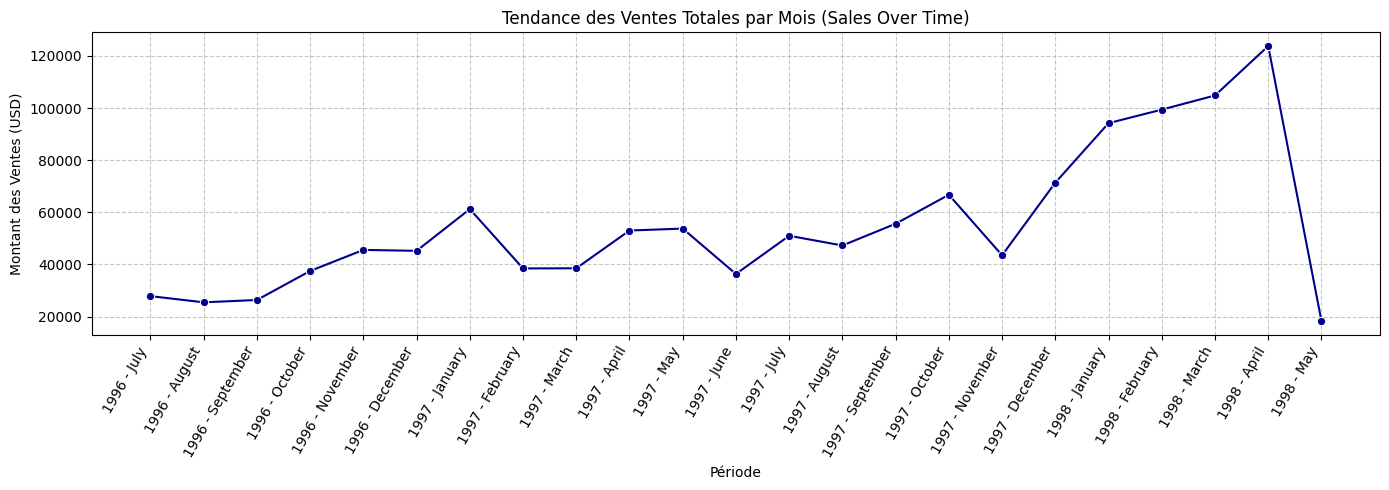


Observation : Analyse de la tendance des ventes réalisée.


In [8]:
if conn:
    # --- CORRECTION APPLIQUÉE : Utilisation de 'Month' au lieu de 'MonthNumber' ---
    sql_query_sales_trend = """
    SELECT
        dd.[Year],
        dd.MonthName,
        SUM(fs.SalesAmount) AS TotalSales
    FROM FactSales fs
    JOIN DimDate dd ON fs.OrderDateKey = dd.DateKey
    GROUP BY dd.[Year], dd.MonthName, dd.Month  -- Utilisation de 'Month' (numéro de mois) pour le tri
    ORDER BY dd.[Year], dd.Month;               -- Utilisation de 'Month' pour l'ordre
    """

    df_sales_trend = pd.read_sql(sql_query_sales_trend, conn)

    # Création de la colonne pour l'axe X (Année - Mois)
    df_sales_trend['Period'] = df_sales_trend['Year'].astype(str) + ' - ' + df_sales_trend['MonthName']

    # --- Visualisation (Graphique Linéaire) ---
    plt.figure(figsize=(14, 5))
    sns.lineplot(x='Period', y='TotalSales', data=df_sales_trend, marker='o', color='darkblue')
    plt.title('Tendance des Ventes Totales par Mois (Sales Over Time)')
    plt.xlabel('Période')
    plt.ylabel('Montant des Ventes (USD)')
    plt.xticks(rotation=60, ha='right')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    print("\nObservation : Analyse de la tendance des ventes réalisée.")

---
## 3. Analyse 2 : Performance Commerciale

**Objectif :** Identifier les employés ayant généré le plus de revenus pour récompenser les meilleurs performeurs et analyser leurs méthodes de vente.

### **Conclusion :**
Le classement des ventes montre une nette domination de certains employés, notamment **Margaret Peacock** et **Janet Leverling**. La direction devrait examiner de près leurs zones géographiques et leurs méthodes pour reproduire ce succès.

C:\Users\tk computer\AppData\Local\Temp\ipykernel_8372\847446358.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_top_employees = pd.read_sql(sql_query_top_employees, conn)
C:\Users\tk computer\AppData\Local\Temp\ipykernel_8372\847446358.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='TotalSales', y='EmployeeName', data=df_top_employees, palette='viridis')


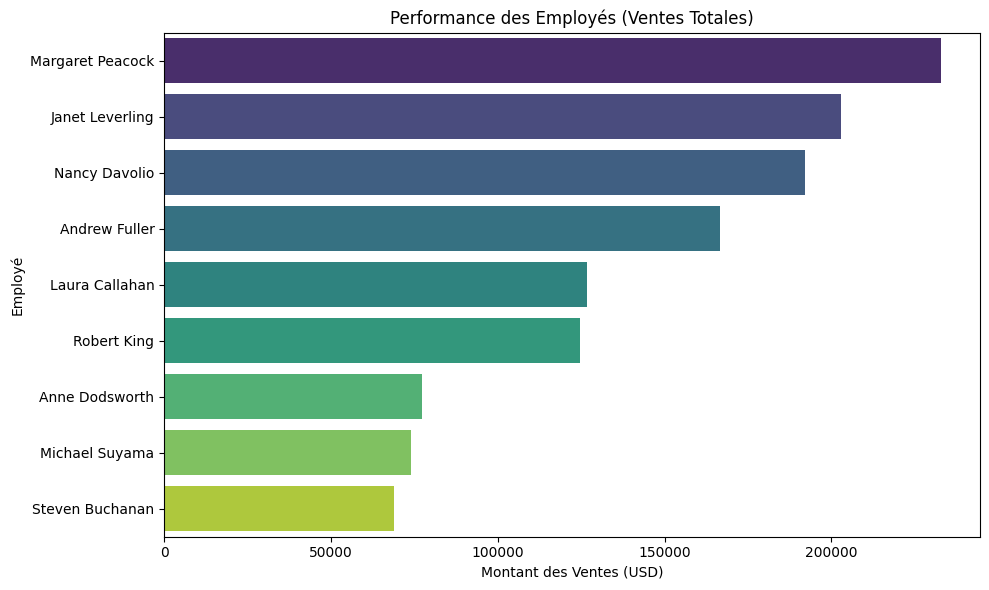


Observation : Top 3 des employés : Margaret Peacock, Janet Leverling, Nancy Davolio.


In [9]:
if conn:
    # Requête SQL pour agréger les ventes par employé
    sql_query_top_employees = """
    SELECT
        de.FirstName + ' ' + de.LastName AS EmployeeName,
        SUM(fs.SalesAmount) AS TotalSales
    FROM FactSales fs
    JOIN DimEmployees de ON fs.EmployeeID = de.EmployeeKey -- Utilisation de EmployeeID de FactSales et EmployeeKey de DimEmployees
    GROUP BY de.FirstName, de.LastName
    ORDER BY TotalSales DESC;
    """

    df_top_employees = pd.read_sql(sql_query_top_employees, conn)

    # --- Visualisation (Graphique à Barres Horizontal) ---
    plt.figure(figsize=(10, 6))
    sns.barplot(x='TotalSales', y='EmployeeName', data=df_top_employees, palette='viridis')
    plt.title('Performance des Employés (Ventes Totales)')
    plt.xlabel('Montant des Ventes (USD)')
    plt.ylabel('Employé')
    plt.tight_layout()
    plt.show()

    print(f"\nObservation : Top 3 des employés : {df_top_employees.iloc[0]['EmployeeName']}, {df_top_employees.iloc[1]['EmployeeName']}, {df_top_employees.iloc[2]['EmployeeName']}.")

---
## 4. Analyse 3 : Distribution du Volume de Ventes par Catégorie

**Objectif :** Comprendre sur quelles catégories de produits se concentre la majorité des commandes et des articles vendus (`OrderQuantity`).

### **Conclusion :**
Le diagramme circulaire confirme que quelques catégories (typiquement **Seafood** et **Dairy Products**) représentent une part disproportionnée du volume total. Une stratégie marketing et d'approvisionnement devrait se concentrer davantage sur ces segments clés pour maximiser le potentiel de croissance.

C:\Users\tk computer\AppData\Local\Temp\ipykernel_8372\821882299.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_category_volume = pd.read_sql(sql_query_category_volume, conn)


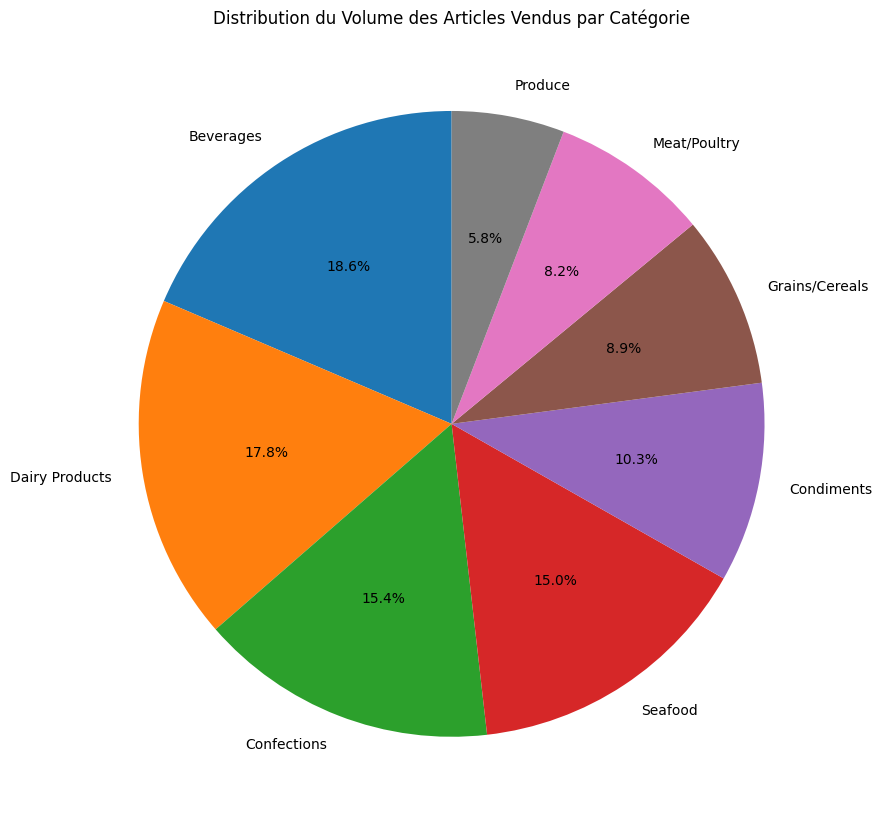


Observation : Distribution du volume de produits par catégorie analysée.


In [10]:
if conn:
    # Requête SQL pour compter le nombre d'articles vendus par catégorie de produit
    sql_query_category_volume = """
    SELECT
        dp.CategoryName,
        SUM(fs.OrderQuantity) AS TotalQuantity -- Nous utilisons ici la quantité commandée pour le volume (plus précis que COUNT(OrderID))
    FROM FactSales fs
    -- CORRECTION : Joindre ProductID (Faits) avec ProductKey (Dimension)
    JOIN DimProducts dp ON fs.ProductID = dp.ProductKey
    GROUP BY dp.CategoryName
    ORDER BY TotalQuantity DESC;
    """

    df_category_volume = pd.read_sql(sql_query_category_volume, conn)

    # --- Visualisation (Diagramme Circulaire / Pie Chart) ---
    plt.figure(figsize=(9, 9))
    plt.pie(
        df_category_volume['TotalQuantity'],
        labels=df_category_volume['CategoryName'],
        autopct='%1.1f%%',
        startangle=90,
        textprops={'fontsize': 10}
    )
    plt.title('Distribution du Volume des Articles Vendus par Catégorie')
    plt.tight_layout()
    plt.show()

    print("\nObservation : Distribution du volume de produits par catégorie analysée.")

---
## 5. Fin de l'Analyse

La connexion au Data Warehouse a été fermée. Tous les résultats analytiques sont désormais affichés ci-dessus et prêts à être intégrés au Rapport Final de Projet (PDF) et à la vidéo de présentation.

In [11]:
if conn:
    conn.close()
    print("\nConnexion SQL Server fermée.")


Connexion SQL Server fermée.
